# Research Question

Can we predict which patients will show up for their appointments versus those who will either cancel last minute or not show up at all?

# Justification

No-shows are a common problem in healthcare. They lead to wasted resources, lost revenue, and can have a negative impact on patient outcomes. By identifying patients who are at risk of not showing up for their appointments, healthcare providers can take steps to reduce the number of no-shows and improve patient outcomes. Additionally, in cases where multiple no-shows seem likely, providers can plan for how best utilize their expected time for other uses.

My wife is a Registered Dietitian and her most common complaint is no-shows. She has a limited number of appointments available each day and when a patient doesn't show up, it's a lost opportunity to help someone else. 

# Potential libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
import scipy.stats as stats

# Data

This dataset was found on Kaggle here https://www.kaggle.com/datasets/joniarroba/noshowappointments/data. It contains information on over 100,000 medical appointments in Brazil. The dataset includes information on patient demographics, medical history, and whether or not the patient showed up for their appointment. I am currently in contact with my wife's employer to see if I can get access to their data to see if I can use it for this project. I haven't received a final answer yet so I do not know for sure if I will be able to use this data. If I do not get it, I will use the data from Kaggle and possibly explore other avenues of finding more data.

As seen in the below table, dataset contains the following variables: It has the patient ID, Appointment ID, their gender, the day the appointment was scheduled, appointment day, age, neighborhood, scholarship status, hypertension, diabetes, alcoholism, handicap status, SMS received as a reminder, and whether or not the patient showed up for their appointment. This dataset is collected from a hospital in Brazil and scholarship status refers to whether or not the patient is enrolled in the Bolsa Familia program which is a social welfare program in Brazil.

In [6]:
file_path = "C:\\Users\\shaya\\OneDrive\\Documents\\Final Project\\Data\\KaggleV2-May-2016.csv"
data = pd.read_csv(file_path)

In [7]:
print(data.head())

      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0      No  
1         0           0        0      

# Exploratory Data Analysis

The below output reveals that the data seems to be very clean and doesn't require much work. There is no missing values and all of the data types are correct. The target variable is the No-show column, which is a character type column with strings "Yes" and "No". We will need to convert this to a binary variable for our model. Gender is also a character column with "M" and "F" values. We will need to convert this to a binary variable as well. The day the appointment was scheduled and the appointment day are both character columns and we will need to convert these to date columns.

In [18]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB
None


From the following output, several important observations can be made about the dataset. Firstly, the average age of patients attending appointments is 37 years, with a considerable spread indicated by a standard deviation of 23 years. There appears to be an outlier in age with a minimum value of -1, which requires further investigation. The dataset includes patients with various medical conditions, such as hypertension (mean prevalence of 20%) and diabetes (7% prevalence), while alcoholism is relatively uncommon (3% prevalence). The majority of patients did not receive SMS reminders (mean proportion of 32%). The statistics also reveal extreme values in the Handcap variable, with a maximum value of 4, suggesting potential data integrity issues or varying definitions of disability levels. Further exploration and cleaning of the dataset are recommended to ensure the accuracy and reliability of subsequent analyses.


In [19]:
print(data.describe())

          PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205       0.297675   
min    3.921784e+04   5.030230e+06      -1.000000       0.000000   
25%    4.172614e+12   5.640286e+06      18.000000       0.000000   
50%    3.173184e+13   5.680573e+06      37.000000       0.000000   
75%    9.439172e+13   5.725524e+06      55.000000       0.000000   
max    9.999816e+14   5.790484e+06     115.000000       1.000000   

        Hipertension       Diabetes     Alcoholism        Handcap  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.197246       0.071865       0.030400       0.022248   
std         0.397921       0.258265       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       

The below bar plots illustrate the distribution of the categorical variables in the dataset. The variables all seem to have heavy class imbalances. This will have to be considered when building the model. It also reinforces that something is wrong with the Handcap variable as it has a value of 4 which should not be possible. We will need to investigate this further.

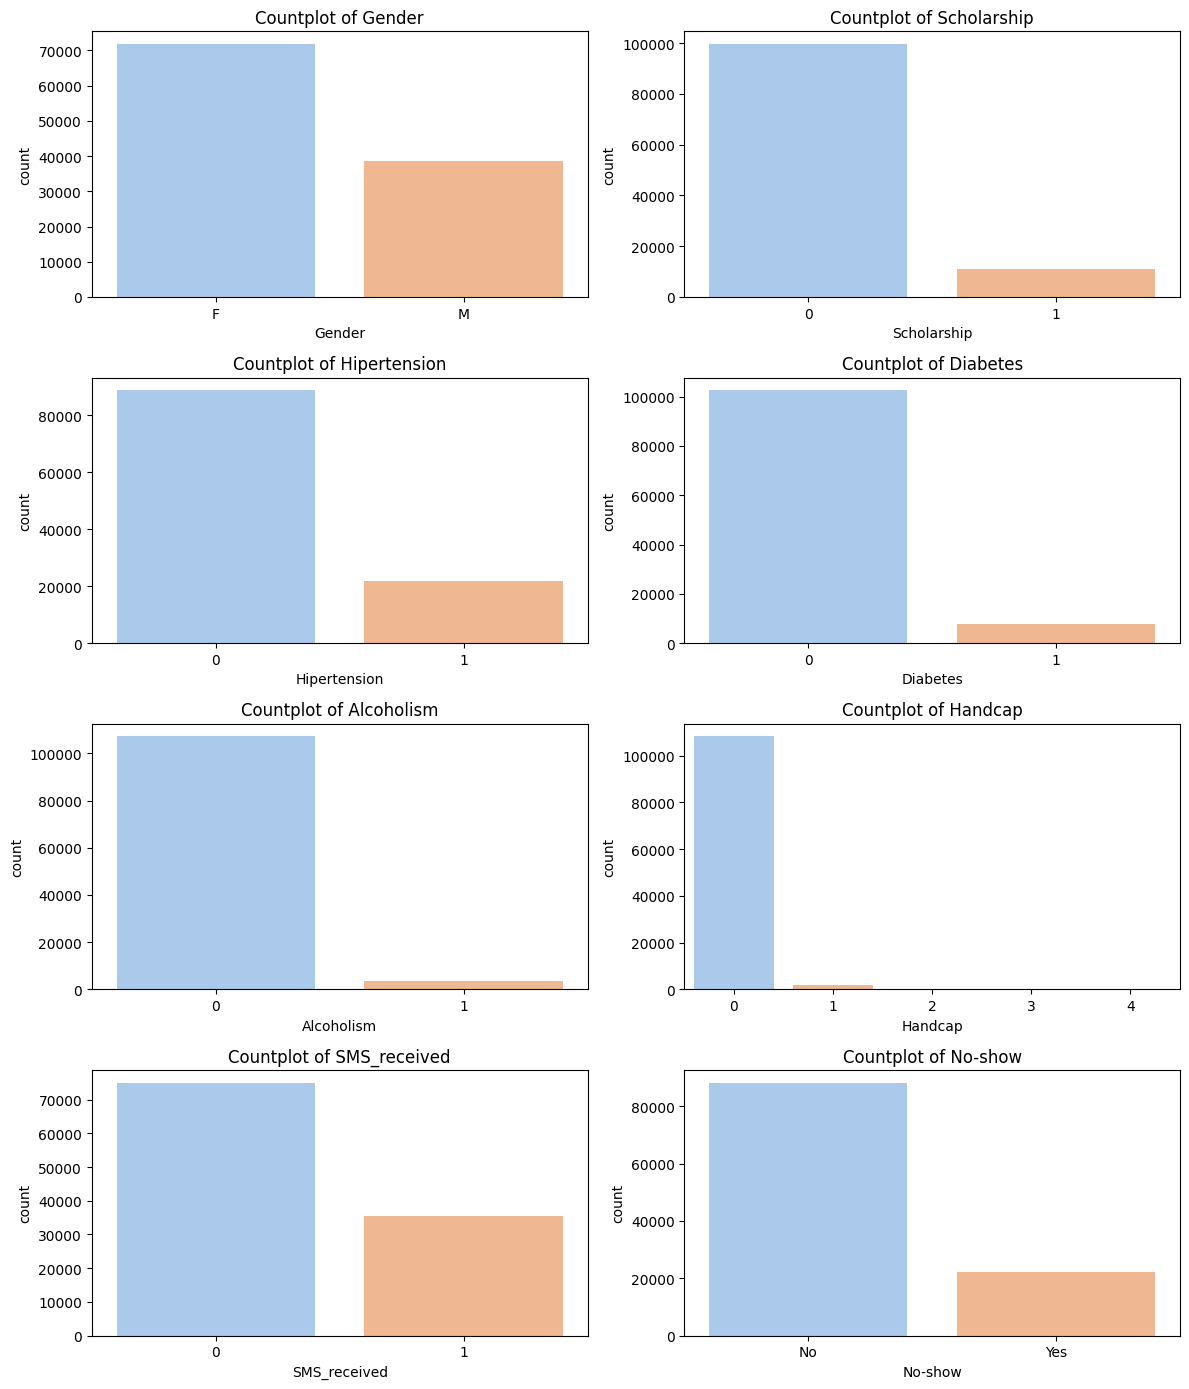

In [14]:
selected_columns = ["Gender", "Scholarship", "Hipertension", "Diabetes", "Alcoholism", "Handcap", "SMS_received", "No-show"]
data_subset = data[selected_columns]

fig, axes = plt.subplots(4, 2, figsize=(12, 14))
axes = axes.flatten()

# Loop through columns and plot countplots
for i, col in enumerate(data_subset.columns):
    sns.countplot(x=col, data=data_subset, ax=axes[i], palette='pastel', hue=col, legend=False)
    axes[i].set_title(f'Countplot of {col}')  # Set title for each subplot

# Adjust layout and show plot
plt.tight_layout()
plt.show()

A boxplot and histogram of the Age column is a good way to visualize the distribution of the ages of patients in the dataset. It also is a great method for visualizing outliers.

The below plots show some alarming results. The box plot shows a minimum age of -1 which is not possible. The histogram shows a peak at 0 which is extremely unlikely as that would  mean that a massively disproportionate number of patients are newborns. This amount of 0s is likely due to missing data and skews the summary of the mean age. This will need to be investigated further.


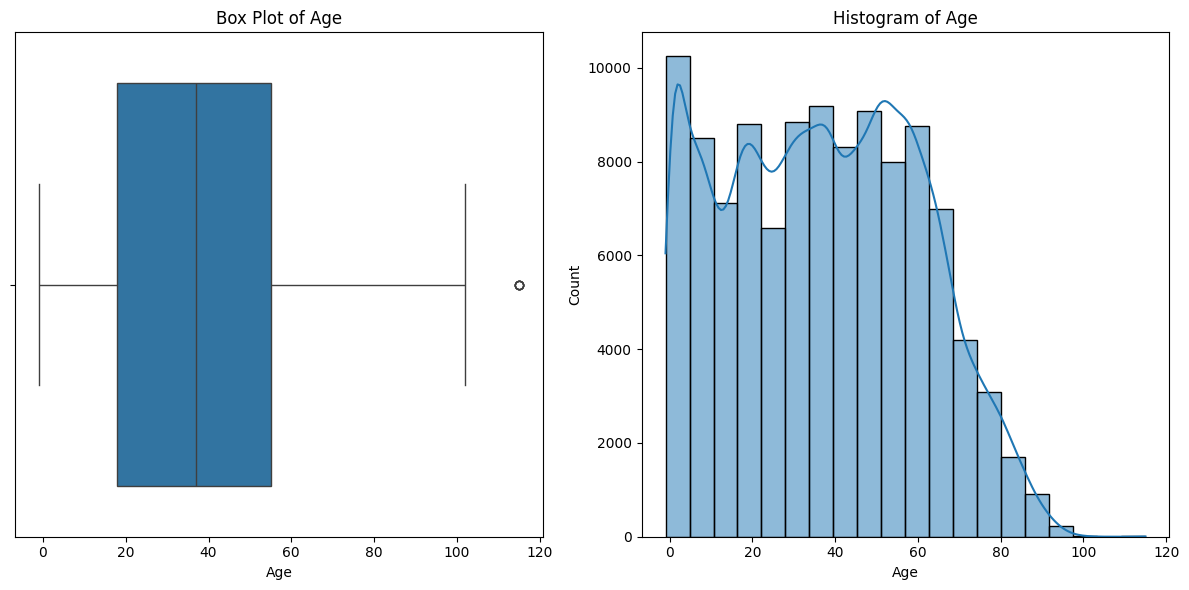

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(x='Age', data=data, ax=axes[0])
axes[0].set_title('Box Plot of Age')

sns.histplot(data['Age'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Histogram of Age')

plt.tight_layout()
plt.show()

Checking for correlation between the predictor variables is very important. For example, the below heatmap reveals a relationship of 0.5 between Age and Hypertension. Any predictions based on this data might assume a stronger relationship between hypertension and no-shows than there truly is independent of age. All this has to be taken into account when analyzing the data.

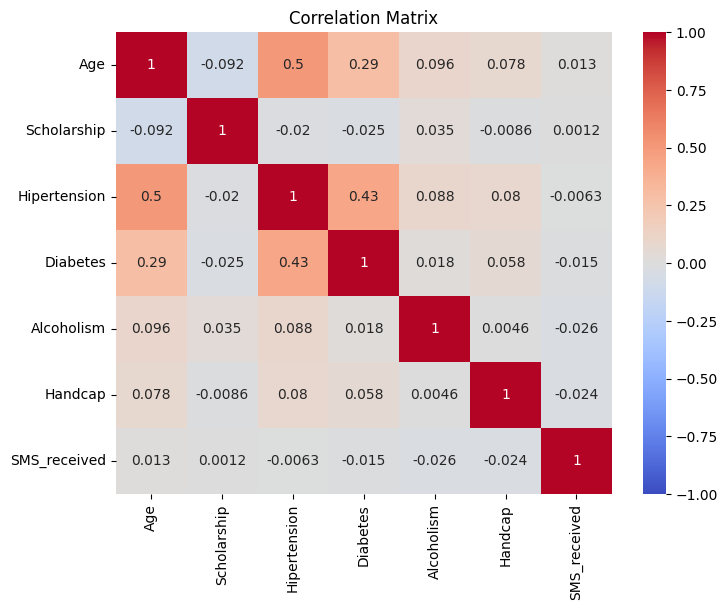

In [16]:
corr_matrix = data[["Age", "Scholarship", "Hipertension", "Diabetes", "Alcoholism", "Handcap", "SMS_received"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()